In [43]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# randomizer
RANDOM_SEED = 666
np.random.seed(RANDOM_SEED)

In [45]:
housing = pd.read_csv('housing.csv')

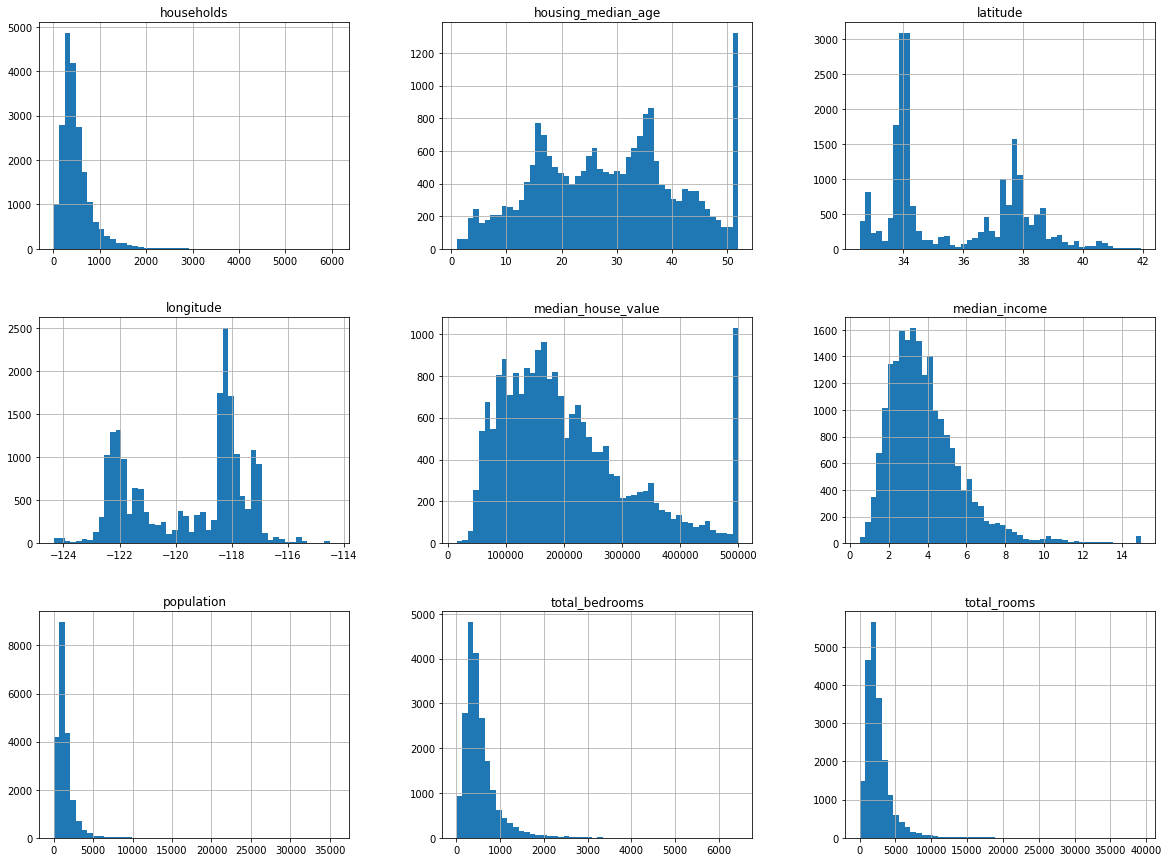

In [46]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [47]:
housing.loc[housing['housing_median_age'].idxmax()]

longitude              -122.24
latitude                 37.85
housing_median_age          52
total_rooms               1467
total_bedrooms             190
population                 496
households                 177
median_income           7.2574
median_house_value      352100
ocean_proximity       NEAR BAY
Name: 2, dtype: object

In [48]:
# clean outliers
cleaned_data = housing[housing['median_house_value'] < 500000]
cleaned_data = cleaned_data[cleaned_data['housing_median_age'] < 52]
cleaned_data = cleaned_data.dropna(axis=0, thresh=2)
print(cleaned_data.count())
print(housing.count())
print(cleaned_data.info())

longitude             18555
latitude              18555
housing_median_age    18555
total_rooms           18555
total_bedrooms        18362
population            18555
households            18555
median_income         18555
median_house_value    18555
ocean_proximity       18555
dtype: int64
longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18555 entries, 0 to 20639
Data columns (total 10 columns):
longitude             18555 non-null float64
latitude              18555 non-null float64
housing_median_age    18555 non-null float64
total_rooms           18555 non-null float64
total_bedrooms        18362 non-null float64
population            18555 non-null float64
households            18555 non-nul

In [49]:
# Constroi uma coluna nova com categorias de renda fictícias.
cleaned_data['income_cat'] = np.ceil(cleaned_data['median_income'] / 1.5)
cleaned_data['income_cat'].where(cleaned_data['income_cat'] < 5, 5.0, inplace=True)
cleaned_data.dropna(inplace=True)

# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(cleaned_data, cleaned_data["income_cat"]):
    strat_train_set = cleaned_data.loc[train_index]
    strat_test_set = cleaned_data.loc[test_index]

# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['income_cat'], axis=1, inplace=True)
strat_test_set.drop(['income_cat'], axis=1, inplace=True)

/home/gil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()
/home/gil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [50]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14689 entries, 11661 to 9810
Data columns (total 10 columns):
longitude             12953 non-null float64
latitude              12953 non-null float64
housing_median_age    12953 non-null float64
total_rooms           12953 non-null float64
total_bedrooms        12953 non-null float64
population            12953 non-null float64
households            12953 non-null float64
median_income         12953 non-null float64
median_house_value    12953 non-null float64
ocean_proximity       12953 non-null object
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


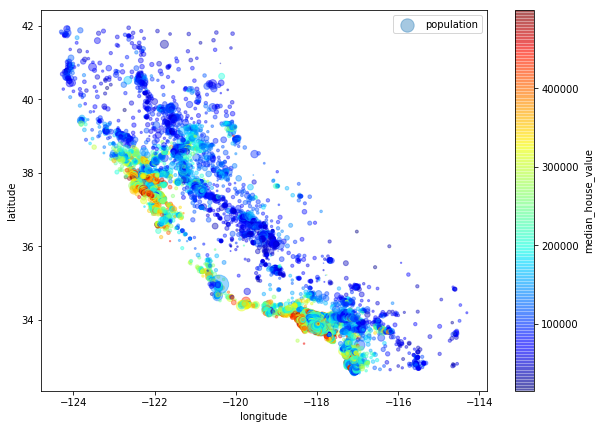

In [51]:
cleaned_data.plot(
    kind="scatter", 
    x="longitude", y="latitude", s=housing["population"]/100, 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    label="population", figsize=(10,7), alpha=0.4,
    sharex=False)
plt.legend()
plt.show()

In [61]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
strat_train_set.dropna(inplace=True)
df = strat_train_set.drop("median_house_value", axis=1)

# Variável dependente, também chamada de label.
df_labels = strat_train_set["median_house_value"].copy()

In [62]:
sample_incomplete_rows = df[df.isnull().any(axis=1)].copy()
#sample_incomplete_rows = sample_incomplete_rows.dropna(axis=0, how='all')
#sample_incomplete_rows
sample_incomplete_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 9 columns):
longitude             0 non-null float64
latitude              0 non-null float64
housing_median_age    0 non-null float64
total_rooms           0 non-null float64
total_bedrooms        0 non-null float64
population            0 non-null float64
households            0 non-null float64
median_income         0 non-null float64
ocean_proximity       0 non-null object
dtypes: float64(8), object(1)
memory usage: 0.0+ bytes


In [63]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [64]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # column index
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = \
            X[:, CombinedAttributesAdder.rooms_ix] / X[:, CombinedAttributesAdder.household_ix]
        population_per_household = \
            X[:, CombinedAttributesAdder.population_ix] / X[:, CombinedAttributesAdder.household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = \
                X[:, CombinedAttributesAdder.bedrooms_ix] / X[:, CombinedAttributesAdder.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer

# df = df.dropna()
housing_num = df.drop('ocean_proximity', axis=1)
housing_cat = df['ocean_proximity']

num_pipeline = Pipeline([
            ('imputer', Imputer(strategy='median')),
            ('attribs_adder', CombinedAttributesAdder()),
            ('std_scaler', StandardScaler()),
        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[ 0.63871192, -0.74161119,  0.57491444, ...,  0.03013422,
         0.05738006, -0.69453475],
       [-0.23623064,  0.98835925, -0.98700122, ...,  0.16662361,
        -0.05674633, -0.29603875],
       [ 0.50489718, -0.65438579,  0.83523372, ..., -0.44122474,
         0.07625798,  0.78341249],
       ...,
       [ 0.76737994, -0.79006974, -1.2473205 , ...,  1.03096111,
         0.10466952, -1.55642493],
       [ 0.56665783, -0.55746868,  1.26909918, ..., -0.23679818,
         0.09898978,  0.11907081],
       [ 1.14823729, -1.32795971, -0.1192703 , ...,  0.33945285,
         0.05406048, -0.84499391]])

In [66]:
cat_pipeline = Pipeline([
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])
housing_cat_tr = cat_pipeline.fit_transform(housing_cat
                                            .values.reshape(-1, 1))
housing_cat_tr

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [68]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [69]:
housing_prepared = full_pipeline.fit_transform(df)
housing_prepared[:5]

array([[ 6.38711920e-01, -7.41611186e-01,  5.74914443e-01,
         3.50637153e-01,  1.36882953e-01,  6.19695632e-01,
         3.18781401e-01,  8.97695620e-01,  3.01342247e-02,
         5.73800561e-02, -6.94534751e-01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.36230636e-01,  9.88359248e-01, -9.87001218e-01,
        -2.37633560e-01, -2.92516027e-01, -4.13208081e-01,
        -3.61369809e-01, -7.02468366e-01,  1.66623611e-01,
        -5.67463331e-02, -2.96038748e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.04897176e-01, -6.54385786e-01,  8.35233720e-01,
        -3.07302926e-01, -9.13765048e-02,  1.57475392e-01,
        -1.23816996e-01, -1.43263409e+00, -4.41224744e-01,
         7.62579842e-02,  7.83412485e-01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.28418478e-01, -6.15618942e

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 6 (2×3) combinations of hyperparameters
    {'n_estimators': [10, 30], 'max_features': [4, 6, 8]},
    # then try 4 (1x2×2) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print(type(df_labels), type(housing_prepared))
print(df_labels.shape, housing_prepared.shape)
grid_search.fit(housing_prepared, df_labels.reshape((-1, 1)))

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
(12953,) (12953, 16)


/home/gil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gil/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vec

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=666, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30], 'max_features': [4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=666,
           verbose=0, warm_start=False)

In [74]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.332880769897388, 'median_income'),
 (0.15613042748216896, 'INLAND'),
 (0.11101323962808458, 'pop_per_hhold'),
 (0.08733018954552024, 'longitude'),
 (0.07096258092811915, 'latitude'),
 (0.0697092669375612, 'bedrooms_per_room'),
 (0.043532214109219154, 'rooms_per_hhold'),
 (0.038704648712498124, 'housing_median_age'),
 (0.01752484140815296, 'total_rooms'),
 (0.016989334114265783, 'total_bedrooms'),
 (0.016486899047201423, 'population'),
 (0.015581014572371125, 'households'),
 (0.015004646336284396, '<1H OCEAN'),
 (0.005755546060685205, 'NEAR OCEAN'),
 (0.002177626741010726, 'NEAR BAY'),
 (0.00021675447946887416, 'ISLAND')]

In [77]:
from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_
strat_test_set.dropna(inplace=True)

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("RMSE = {}".format(final_rmse))
print('RMSE percentage = {}'.format(final_rmse / y_test.mean()))

RMSE = 43793.814851025316
RMSE percentage = 0.22683422263055142
